## Bélády's Anomaly Demonstration

The intention of this notebook is to demonstrate [Bélády's Anomaly](https://en.wikipedia.org/wiki/B%C3%A9l%C3%A1dy%27s_anomaly) on a cache that uses a FIFO replacement policy. This notebook will mock several fully-associated caches of size $C \in \{4 ... 100\}$. Each entry in the cache is just a reference to the frame and does not contain any other information. This is just to demonstrate this type of anomaly that can occur with these types of caches.

Each test will have a progressively larger number of possible accesible frames--matching the number of available cache entries plus one. This ensures that there will be at least some page faults for each test. Each test randomly generates 100 mock page frame accesses and then counts the number of page faults that occur.

In [37]:
import random
import queue


class IterableQueue(queue.Queue):
    """Queue class that allows inspection of the contents of the queue. This is accomplished
    by storing all inserted objects into a dictionary. This allows the user to check whether
    or not some item exists somewhere in the queue. It also allows for an interator to list
    off all items in the queue (though their ordering is not guaranteed to be exact).
    """
    def __init__(self, maxsize=0):
        super(IterableQueue, self).__init__()
        self._contents = {}
    
    def put(self, item, block=True, timeout=None):
        super(IterableQueue, self).put(item, block=block, timeout=timeout)
        
        if item in self._contents:
            self._contents[item] += 1
        else:
            self._contents[item] = 1

    def get(self, block=True, timeout=None):
        item = super(IterableQueue, self).get(block=block, timeout=timeout)
        
        if not self._contents[item] - 1:
            del self._contents[item]
        else:
            self._contents[item] -= 1
    
    def __contains__(self, item):
        return item in self._contents
    
    def __iter__(self):
        return self
    
    def __next__(self):
        for k, v in self._contents.items():
            for _ in range(v):
                yield k


def simulate_fifo_cache(total_frame_count_func):
    """Generates a list of integers representing the number of page faults that occured during
    the cache simulation. Takes a function that determines how many possible frames there will
    be based on the size of the cache.
    """
    num_faults = [0] * 97
    for idx, cache_size in enumerate(range(4, 101)):
        cache = IterableQueue(maxsize=cache_size)
    
        # List of frames to access.
        frame_accesses = [
            random.randrange(0, total_frame_count_func(cache_size)) for _ in range(100)
        ]
    
        for frame in frame_accesses:
            if cache.full():
                cache.get_nowait()
        
            if not frame in cache:
                num_faults[idx] += 1
        
            cache.put(frame)
            
    return num_faults

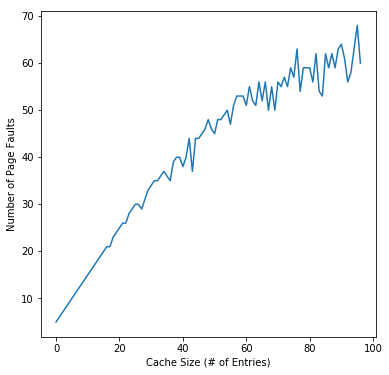

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

plt.plot(simulate_fifo_cache(lambda x: x + 1))

plt.xlabel('Cache Size (# of Entries)')
plt.ylabel('Number of Page Faults')
plt.show()

In this case you can see that even with a larger cache size, the number of page faults still increases.